# Investigating English Phonotactics #
In the notebook `Model Training.ipynb` I trained a language model over English pronunciations from [the CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict). The pronunciations in the pronouncing dictionary are in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols representing English sounds. It's a subset of the more popular [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet).

In this notebook I use the model to:
1. **Identify which English pronunciations are most- and least-Englishlike**. For example, I would expect "fun" to sound normal and a borrowed word like "cliché" to be less normal.
2. **Generate novel words** that aren't English words but sound like they could be.

I'll also dig into what the model has learned to see whether it has learned the [phonotactics rules](https://en.wikipedia.org/wiki/Phonotactics) that all English speakers subconsciously understand.

In [199]:
from operator import itemgetter

import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


from sonorous.analysis_utils import plot_next_phoneme_distribution, plot_pronunciation_probability
from sonorous.languagemodel import LanguageModel
from sonorous.utils import perplexity
from sonorous.pronunciationdata import augment_pronunciations_df, load_pronunciations

In [9]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 255

First I'll load the model that I trained in `Model Training.ipynb`.

In [10]:
with open('phoneme_language_model.pt', 'rb') as fh:
    language_model = LanguageModel.load(fh, device_name='cpu')

In [11]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")
pronunciations.sample(5)

There are 125,801 pronunciations.

Sample of 5 pronunciations:


,pronunciation,num_phonemes,num_syllables
word,,,
nonbuilding,"(N, AA1, N, B, IH1, L, D, IH0, NG)",9,3
braaksma,"(B, R, AA1, K, S, M, AH0)",7,2
talkies,"(T, AO1, K, IY0, Z)",5,2
bamut,"(B, AE1, M, AH0, T)",5,2
askington,"(AE1, S, K, IH0, NG, T, AH0, N)",8,3


## What Words are the Most and Least Englishy? ##
Since the model can assign a probability to any pronunciation, I can run it over the entire set of pronunciations in the Pronouncing Dictionary and identify the ones that have high and low likelihood of being English.

I'll be using [perplexity](https://en.wikipedia.org/wiki/Perplexity) as a measurement of how likely the model thinks each pronunciation is.

In [13]:
%%time

pronunciations['perplexity'] = pronunciations.pronunciation.apply(language_model.perplexity_of_text)

CPU times: user 1min 24s, sys: 82.2 ms, total: 1min 24s
Wall time: 1min 24s


In [80]:
pronunciations.sort_values('perplexity', inplace=True)

Let's look at the least perplexing words. These are the ones the model was totally unsurprised because they seem very normal.

In [81]:
least_perplexing = pronunciations.head(10)
least_perplexing

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
preponderance,"(P, R, IY0, P, AA1, N, D, R, AH0, N, S)",11,3,63.210280
semiconductor,"(S, EH2, M, IY0, K, AH0, N, D, AH1, K, T, ER0)",12,5,67.137983
android,"(AE1, N, D, R, OY2, D)",6,2,67.268752
prindiville,"(P, R, IY0, N, D, IY1, V, IH0, L)",9,3,67.667500
nigeria,"(N, AY0, JH, IH1, R, IY0, AH0)",7,4,69.417881
roundhead,"(R, AW1, N, D, HH, EH2, D)",7,2,69.603606
recurrence,"(R, IY0, K, ER1, AH0, N, S)",7,3,69.681412
aspects,"(AE1, S, P, EH2, K, T, S)",7,2,70.102861
bacterial,"(B, AE0, K, T, IH1, R, IY0, AH0, L)",9,4,70.182127


The least perplexing words have long spans of phonemes that are very common in Enligh. To get better intuitions about the model's "thinking" along the way we can look at the probability the model assigned to each phoneme. In the chart below, the phonemes occur along the X-axis. At the `i`th phoneme the Y-axis value represents how likely the model thought this character is given everything it's seen so far. For example, at the third phoneme below (/N/) the probability of ~.5 means the model thinks that after seeing /K AA2/ the probability of /N/ coming next is .5. In other words, `P(N | K AA2) = 0.5)`.

In [18]:
print(' '.join(least_perplexing.pronunciation.iloc[0]))

P R IY0 P AA1 N D R AH0 N S


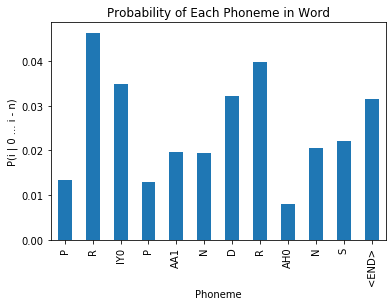

In [56]:
plot_pronunciation_probability(language_model, least_perplexing.pronunciation.iloc[0])

It is clear that the model has memorized some of these longer words. In the word "constitutionists" above, early on perplexity is high as the model was trained on many words that had that same beginning. Further on the model is fairly certain, like where it believes /SH/ should almost certaintly follow /K AH2 N S T AH0 T UW1/. Phonotactically many of phonemes would be fine here.


It makes sense that the model would be able to overfit on long words. What short words are most perplexing to the model? Let's look at the most perplexing two syllable words.

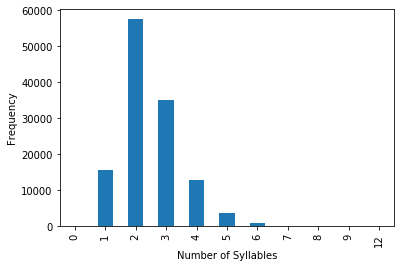

In [59]:
pronunciations.num_syllables.value_counts().sort_index().plot.bar()
plt.xlabel('Number of Syllables')
_ = plt.ylabel('Frequency')

In [60]:
percentage_2to3 = (pronunciations.num_syllables==2).mean() * 100
print('{:.0f}% of words contain two syllables\n'.format(percentage_2to3))

46% of words contain two syllables



In [63]:
pronunciations_2

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
aaberg,"(AA1, B, ER0, G)",4,2,287.721510
aachen,"(AA1, K, AH0, N)",4,2,222.437659
aaker,"(AA1, K, ER0)",3,2,208.827698
aalseth,"(AA1, L, S, EH0, TH)",5,2,197.804684
aamodt,"(AA1, M, AH0, T)",4,2,373.506562
...,...,...,...,...
zyla,"(Z, IH1, L, AH0)",4,2,203.472098
zylka,"(Z, IH1, L, K, AH0)",5,2,199.136245
zylstra,"(Z, IH1, L, S, T, R, AH0)",7,2,167.791326


About 46% of English words contain two syllables. So let's look in this area.

In [66]:
pronunciations[pronunciations.num_syllables==2].drop_duplicates('pronunciation').head(10)

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
android,"(AE1, N, D, R, OY2, D)",6,2,67.268752
roundhead,"(R, AW1, N, D, HH, EH2, D)",7,2,69.603606
aspects,"(AE1, S, P, EH2, K, T, S)",7,2,70.102861
boundary,"(B, AW1, N, D, R, IY0)",6,2,71.095841
roadside,"(R, OW1, D, S, AY2, D)",6,2,71.223020
landslide,"(L, AE1, N, D, S, L, AY2, D)",8,2,71.504970
ovoid,"(OW1, V, OY2, D)",4,2,72.516474
fredlund,"(F, R, EH1, D, L, AH0, N, D)",8,2,74.790781
rexrodt,"(R, EH1, K, S, R, OW0, D)",7,2,75.410295


In [68]:
pronunciations[pronunciations.num_syllables > 3].drop_duplicates('pronunciation').head(10)

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
semiconductor,"(S, EH2, M, IY0, K, AH0, N, D, AH1, K, T, ER0)",12,5,67.137983
nigeria,"(N, AY0, JH, IH1, R, IY0, AH0)",7,4,69.417881
bacterial,"(B, AE0, K, T, IH1, R, IY0, AH0, L)",9,4,70.182127
bacteria,"(B, AE0, K, T, IH1, R, IY0, AH0)",8,4,70.184858
nigerians,"(N, AY0, JH, IH1, R, IY0, AH0, N, Z)",9,4,71.258426
reclassified,"(R, IY0, K, L, AE1, S, AH0, F, AY2, D)",10,4,71.747827
nigerian,"(N, AY0, JH, IH1, R, IY0, AH0, N)",8,4,71.960878
semiannually,"(S, EH2, M, IY0, AE1, N, UW0, L, IY0)",9,5,72.509141
quadrennial,"(K, W, AA0, D, R, EH1, N, IY0, AH0, L)",10,4,72.816431


All of these words have three syllables with the stress on the second syllable. These all feel like good English words. They have many phonemes though, so I'm concerned that the model is recognizing the very specific patterns and giving all the later phonemes very high probabilities.

In [71]:
pronunciations[pronunciations.num_phonemes == 2].sort_values('perplexity', ascending=False).head(10)

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
toye,"(T, OY1)",2,1,3383.548352
toy,"(T, OY1)",2,1,3383.548352
it,"(IH1, T)",2,1,2994.882099
aung,"(AO1, NG)",2,1,2835.244216
ong,"(AO1, NG)",2,1,2835.244216
engh,"(EH1, NG)",2,1,2745.704642
ng,"(EH1, NG)",2,1,2745.704642
eng,"(EH1, NG)",2,1,2745.704642
tai,"(T, AY1)",2,1,2666.655514


Interestingly these words do all feel very weird to me as an English speaker. "ai" is an acronym, pronounced as the letter 'A' followed by the letter 'I', so isn't held to normal word formation properties and would be a really strange word.

"zungu" also doesn't sound like English. Since English prefers syllables with onsets, when saying the word I feel like I want /NG/ to be the onset of the second syllable /NG UW1/. But /NG/ isn't normally allowed as the onset of a syllable.

The stress pattern is also weird on this word. Normally in a two syllable word there will be one stressed syllable and one unstressed. This word has primary stress on the second syllabie (/UW1/) and secondary stressed on the first syllable (/AH2/). Interestingly, the perplexity of the word drops considerably (to 450) when I replace /AH2/ with /AH1/.

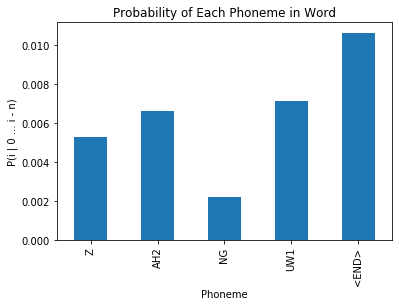

In [72]:
plot_pronunciation_probability(language_model, ('Z', 'AH2', 'NG', 'UW1'))

We've seen that the lowest perplexity words are very long and the highest perplexity words are short. Let's look at the two other options. First let's look at the low perplexity short words.

In [82]:
pronunciations[pronunciations.num_phonemes == 2].drop_duplicates('pronunciation').head()

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
rao,"(R, AW1)",2,1,191.833026
bao,"(B, AW1)",2,1,226.253332
be,"(B, IY0)",2,1,250.194332
owed,"(OW1, D)",2,1,268.237357
al,"(AE1, L)",2,1,270.992585


In [ ]:
plot_pronunciation(lm, ('K', 'R', 'IH1', 'S', 'T', 'AH0', 'L'))

Despite being only two syllables, these words are packed with phonemes, with lots complex onsets and codas. Let's look at words that are three or fewer phonemes.

In [83]:
pronunciations[pronunciations.num_phonemes <= 3].drop_duplicates('pronunciation').head()

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
raul,"(R, AW1, L)",3,1,112.943972
arey,"(AE1, R, IY0)",3,2,115.402145
prow,"(P, R, AW1)",3,1,118.241186
okey,"(OW1, K, IY0)",3,2,120.025465
rouse,"(R, AW1, S)",3,1,122.038554


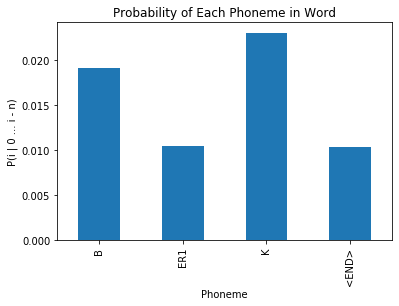

In [84]:
plot_pronunciation_probability(language_model, ('B', 'ER1', 'K'))

These words are all of the form ONSET VOWEL CODA. Overall they all sound like standard words.

Now lets look at long and perplexing words.

Let's now look at the words the model thinks are most perplexing (i.e. least likely).

In [78]:
pronunciations[pronunciations.num_syllables > 4].sort_values('perplexity', ascending=False).head()

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
apparatuses,"(AE2, P, ER0, AE1, T, AH0, S, AH0, Z)",9,5,288.444800
takashimaya,"(T, AA2, K, AA2, SH, IH0, M, AA1, Y, AH0)",10,5,281.047058
alliterative,"(AH0, L, IH1, T, ER0, AH0, T, IH0, V)",9,5,271.830475
intuitively,"(IH2, N, T, UW1, IH0, T, IH0, V, L, IY0)",10,5,262.825289
alliterative,"(AH0, L, IH1, T, ER0, EY2, T, IH0, V)",9,5,261.828303


Aside from "gunatilake", all of these words are acronyms. For example, "wor" is each letter in the word pronounced.

## Which Pronunciation Wins for Words with Multiple Pronunciations? ##
Another interesting thing we can look at is which pronunciation the model prefers when a word has multiple standard ones.

In [85]:
pronunciations.loc['tomato']

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
tomato,"(T, AH0, M, EY1, T, OW2)",6,3,303.932414
tomato,"(T, AH0, M, AA1, T, OW2)",6,3,320.180485


Let's look at the model's preferred pronunciations for three words commonly argued over.

In [92]:
display(pronunciations.loc['tomato'])
display(pronunciations.loc['aunt'])
display(pronunciations.loc['nevada'])

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
tomato,"(T, AH0, M, EY1, T, OW2)",6,3,303.932414
tomato,"(T, AH0, M, AA1, T, OW2)",6,3,320.180485


,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
aunt,"(AE1, N, T)",3,1,408.755672
aunt,"(AO1, N, T)",3,1,556.478450


,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
nevada,"(N, AH0, V, AE1, D, AH0)",6,3,204.864863
nevada,"(N, AH0, V, AA1, D, AH0)",6,3,312.491040


The model agrees with (what I take to be) the more common pronunciation of the first two words but thinks "Nevada" is different than how I say it.

Let's look at "coupon" now.

In [93]:
pronunciations.loc['coupon']

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
coupon,"(K, Y, UW1, P, AO2, N)",6,2,174.557749
coupon,"(K, UW1, P, AO2, N)",5,2,205.282903


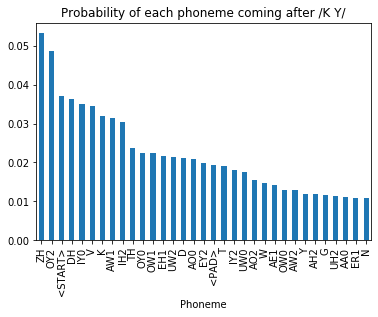

In [95]:
plot_next_phoneme_distribution(language_model, ('K', 'Y'))

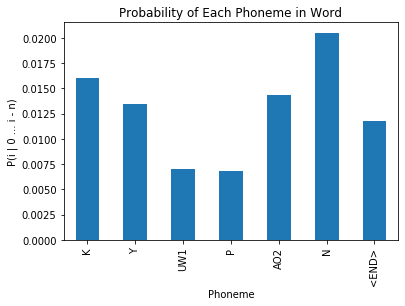

In [96]:
plot_pronunciation_probability(language_model, tuple('K Y UW1 P AO2 N'.split()))

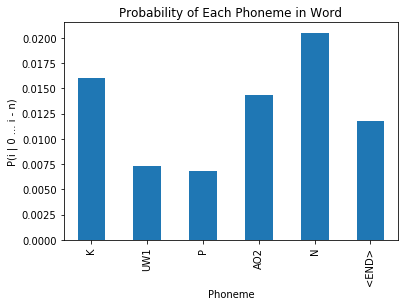

In [97]:
plot_pronunciation_probability(language_model, tuple('K UW1 P AO2 N'.split()))

The model prefers the "YU" less version of "coupon". Interestingly, in this case the relatively low perplexity seems to be due to the model being very certain that /UW1/ will follow /K Y/.

"with" has four possible pronunciations listed.

In [98]:
pronunciations.loc['with']

,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
with,"(W, IH1, TH)",3,1,440.591315
with,"(W, IH0, TH)",3,1,486.737671
with,"(W, IH1, DH)",3,1,513.289812
with,"(W, IH0, DH)",3,1,567.809484


By far the least perplexing one is the one I personally would use. The Pronouncing Dictionary includes two pronunciatinos with an unstressed vowel. When actually spoken in a sentence it'd be common to not stress that vowel, but when just saying the word on its own I would think it should have stress.

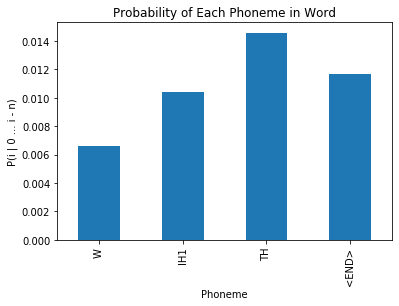

In [99]:
plot_pronunciation_probability(language_model, ('W', 'IH1', 'TH'))

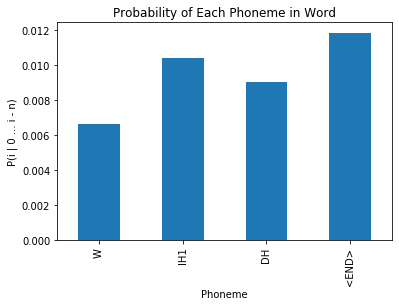

In [100]:
plot_pronunciation_probability(language_model, ('W', 'IH1', 'DH'))

The model also strongly believes "with" should end with the voiceless /TH/ instead of the voiced /DH/. It looks like this is due to the model not wanting to end the word at /W IH1 DH/, probably because ending any word with /IH1 DH/ is rare.

## Can the Model Generate Novel Words? ##

* proportion of words that are novel
* proportion of words (from a sample) that look good to me
* 10 randomly sampled words. show them and play the word. ARPABET | IPA | my best spelling guess | play button 


compare with overgenerated model. probably way more that aren't novel

In [114]:
generated_pronunciations = pd.DataFrame({
    'pronunciation': [
        language_model.generate(max_length=1000)
        for _ in range(100)
    ]
})

generated_pronunciations['is_novel_word'] = ~generated_pronunciations.pronunciation.isin(pronunciations.pronunciation)
augment_pronunciations_df(generated_pronunciations)

# Occasionally the model generates empty pronunciations.
generated_pronunciations = generated_pronunciations[generated_pronunciations.num_phonemes > 0]

generated_pronunciations.sample(10)

,pronunciation,is_novel_word,num_phonemes,num_syllables
87,"(D, B, AO0, N, CH, AY0, F, D, EH2, AE0, AO0, EH0, IY0, OW2, IY0, AH2, OY2, S, AH0, HH, ER2, ER1, OW1)",True,23,15
86,"(AA0, AE1, B, OW1, EH1, K, AO0, F, AY2, ZH, DH, K, OY0, AO2, AY1, OY2, EH1, G, AW1, IH0, B)",True,21,13
71,"(F, T, UH1, OY2, N, Z, EY2, AA1, M, UH1, IY0, AO2, IY2, OW2, OW1, K, EH1, ZH, IY0, OW0, OY1, V, L, AA1, DH)",True,25,15
47,"(UW1, EY2, AO0, AY2, ER2)",True,5,5
48,"(AY2, UH0, EY2, ER2, P, AA2, UW2, AE0, EY2)",True,9,8
66,"(CH, L, L, UW0, G, JH)",True,6,1
33,"(TH, OY2, ER1, AO2, HH, TH, AE0, D, IY0, OW2, EH1, OY2, IH0, AA2, UW2, IY0, N, ER0, ER2, P, AE0, V)",True,22,15
39,"(EY2,)",True,1,1
45,"(D, B, OW0, ER1, AW1)",True,5,3
64,"(P, EY1, R, OW1, K, ZH, CH, Y, IY2, S, L, ER2, SH, AE2, TH, AA1, AO1, OY2, EH0, AH2)",True,20,10


I generated 10,000 new pronunciations. Of those, 75% are novel pronunciations and 25% were in the training set.

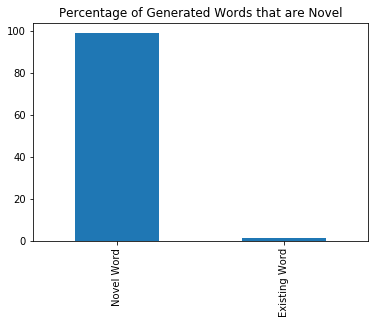

In [127]:
def show_proportion_novel(generated_pronunciations):
    counts = generated_pronunciations.is_novel_word.value_counts()
    percentages = counts / counts.sum() * 100
    
    percentages.index = percentages.index.map({True: 'Novel Word', False: 'Existing Word'})
    percentages.plot.bar()
    plt.title('Percentage of Generated Words that are Novel')

show_proportion_novel(generated_pronunciations)    

Here are some randomly generated proununciations. I'm printing five pronunciations for each syllable count. Note that these are all novel words.

In [120]:
generated_pronunciations[:0].empty


True

In [125]:
novel_generated_pronunciations = generated_pronunciations[generated_pronunciations.is_novel_word]

for num_syllables in range(1, 5):
    
    novel_with_syllable_count = novel_generated_pronunciations[novel_generated_pronunciations.num_syllables==num_syllables]
    if novel_with_syllable_count.empty:
        break
    
    print(f'These have {num_syllables} syllables')

    for pronunciation in novel_with_syllable_count.sample(min(5, len(novel_with_syllable_count))).pronunciation:
        print(f'\t{pronunciation}')

These have 1 syllables
	('AE2', 'V', 'DH')
	('UH0', 'DH')
	('ZH', 'B', 'AE1')
	('CH', 'L', 'L', 'UW0', 'G', 'JH')
	('V', 'W', 'Y', 'HH', 'EY2')
These have 2 syllables
	('R', 'EY1', 'AA2', 'K', 'TH')
	('IY1', 'OW1')
	('AE2', 'T', 'EH2')
	('IY2', 'ER0')
	('Y', 'DH', 'EH2', 'OY0')
These have 3 syllables
	('D', 'B', 'OW0', 'ER1', 'AW1')
	('EY2', 'ER2', 'UH0')
	('UW1', 'N', 'L', 'OW1', 'UW2')
	('AO0', 'W', 'TH', 'R', 'EY2', 'DH', 'OY1')
	('AW2', 'AW0', 'AW0')
These have 4 syllables
	('EH2', 'OY2', 'OW1', 'V', 'EY2')
	('P', 'L', 'AH1', 'OW0', 'K', 'AW0', 'OY2')
	('F', 'AH2', 'AH2', 'K', 'HH', 'L', 'P', 'AE1', 'L', 'EH2')
	('ER2', 'AY1', 'AE0', 'N', 'AO1', 'Y')


The main thing that jumps out at me is that these all sound like conceivable English words. There are a few sort of awkward words, like /G OW1 JH D/, but there's nothing unpronouncable. And the stress patterns feel natural to me.



The length of the words the model generates (both in terms of phonemes and syllables) is fairly similar to the training data.

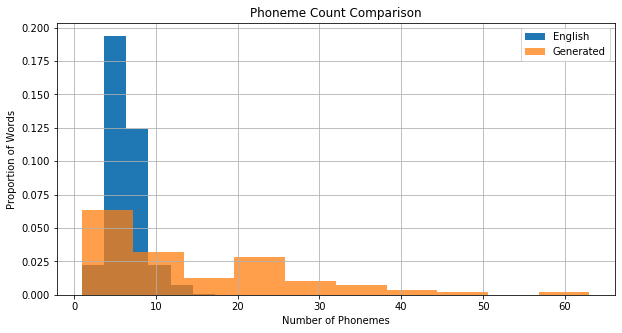

In [134]:
pronunciations.num_phonemes.hist(density=True, figsize=(10, 5), label='English')
generated_pronunciations.num_phonemes.hist(density=True, alpha=.75, label='Generated')
plt.xlabel('Number of Phonemes')
plt.ylabel('Proportion of Words')
plt.title('Phoneme Count Comparison')
_ = plt.legend()

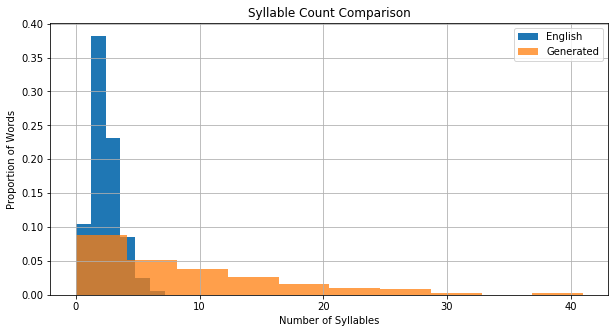

In [137]:
pronunciations.num_syllables.hist(density=True, figsize=(10, 5), label='English')
generated_pronunciations.num_syllables.hist(density=True, alpha=.75, label='Generated')
plt.xlabel('Number of Syllables')
plt.ylabel('Proportion of Words')
plt.title('Syllable Count Comparison')
_ = plt.legend()

In the next section I'll probe the model to figure out whether it's just getting lucky or has learned something.

## What Rules is the Model Actually Learning? ##

Given the overfitting examples we saw earlier where the model had memorized "constitutional" and similar words, I wanted to probe the model to make sure it's learning some more general properties.

An interesting place to start is at the start of each generated pronunciation. Here are the probabilities for the first phoneme in a word:

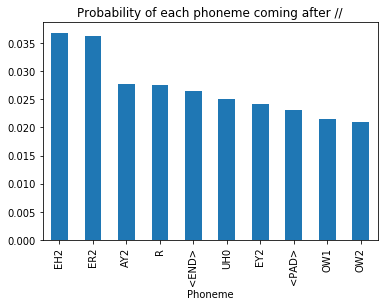

In [140]:
plot_next_phoneme_distribution(language_model, (), min_probability=0.02)

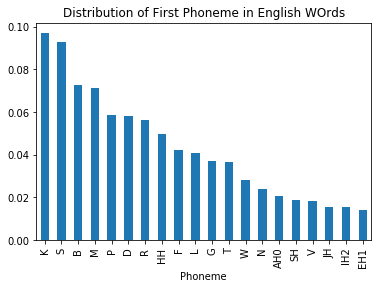

In [149]:
first_phoneme_counts = pronunciations.pronunciation.apply(itemgetter(0)).value_counts()
(first_phoneme_counts / first_phoneme_counts.sum())[:20].plot.bar()
plt.xlabel('Phoneme')
_ = plt.title('Distribution of First Phoneme in English WOrds')

The model's probabilities almost exactly match the actual distribution of first phonemes in the training set. I was hoping that the model might learn some more general properties, like that obstruents (e.g. /K/, /P/, /D/) are equally likely to occur at the beginning of the word, but I appear to have given the model enough capacity to learn more specific sound transition probabilities. This is arguably better since the model can differentiate between very likely English pronunciations instead of just valid ones.

Some quick background on English word structure first. Words are composed of syllables. A syllable consists of an onset, a nucleus, and a coda. The nucleus is usually a vowel (or syllablic consonant like /ER/). The syllable /K R EH1 P T/ has /K R/ in the onset, /EH1/ in the nucleus, and /P T/ in the coda.

English prefers that syllables at the end of a word have a coda. Consonants can serve as the codas of syllables. Diphthongs (/EY/, /OW/, /AW/, /OY/, /IY/) also have coda.

Compare the two pronunciations below, /K EY1/ and /KEH1/.

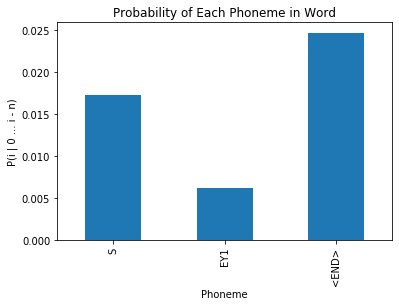

In [153]:
plot_pronunciation_probability(language_model, ("S", "EY1"))

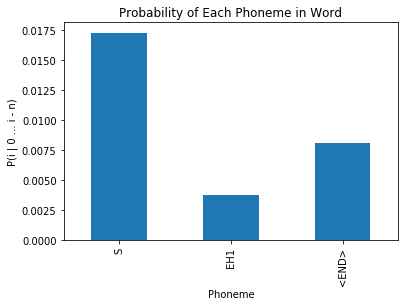

In [154]:
plot_pronunciation_probability(language_model, ("S", "EH1"))

After /S EY1/ the model assigns a 3% probability of the word ending. But /S EH1/ doesn't have a coda, so the model assigns a 0% probability of the word ending.

By closing /S EH1/ with /D/ below, we create a complete word.

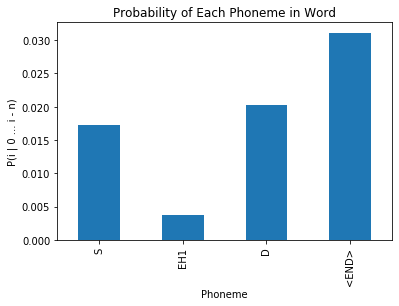

In [156]:
plot_pronunciation_probability(language_model, ("S", "EH1", "D"))

The model also seems to have learned some intersting stress patterns.

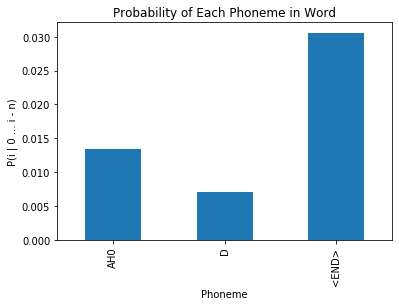

In [155]:
plot_pronunciation_probability(language_model, ('AH0', 'D'))

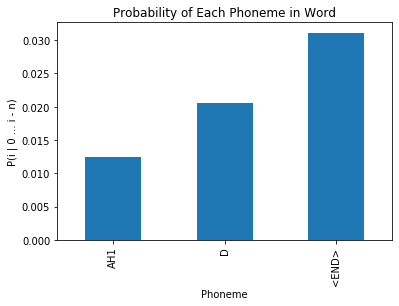

In [157]:
plot_pronunciation_probability(language_model, ('AH1', 'D'))

It knows that the word /AH0 D/ is very unlikely (it assigns a 0 probability to the word ending there) because a word has to have some stress in it. /AH1 D/ is fine though because it's stressed.

The model also learned patterns about stress over multiple syllables. A *foot* is a pair of syllables. A *trochee* contains a stressed syllable followed by an unstressed one. And an *iamb* is an unstressed syllable followed by a stressed one.

English, in general, prefers trochees. This implies that the model should assign a lower perplexity to trochees than iambs.

In [162]:
print('Trochee: {:.2f}'.format(language_model.perplexity_of_text(("T", "R", "OW1", "K", "IY0"))))
print('Iamb:    {:.2f}'.format(language_model.perplexity_of_text(("T", "R", "OW0", "K", "IY1"))))

Trochee: 122.84
Iamb:    229.70


It does in fact prefer the trochee versions in both cases.

Another English phonotactic rule, from Wikipedia, is: "Two obstruents in the same coda must share voicing (compare kids /K IH1 D Z/ with kits /K IH1 T S/)". Hopefully the model will assign a higher perplexity when this rule is violated below.

In [164]:
print('Perplexity for /T EH1 B Z/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'Z'))))
print('Perplexity for /T EH1 B S/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'S'))))
print()
print('Perplexity for /T EH1 P S/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'S'))))
print('Perplexity for /T EH1 P Z/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'Z'))))

Perplexity for /T EH1 B Z/: 647
Perplexity for /T EH1 B S/: 429

Perplexity for /T EH1 P S/: 296
Perplexity for /T EH1 P Z/: 522


Perplexity is higher when the two phonemes in the coda do not match in voicing. The model could just be learning that adjacent phonemes should ideally share voicing though. To test whether it's actually learned the rule about voicing in codas I'll change the syllable structure.

In [165]:
print('Perplexity for /T EH1 B Z AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'Z', 'AH0'))))
print('Perplexity for /T EH1 B S AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'S', 'AH0'))))
print()
print('Perplexity for /T EH1 P Z AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'Z', 'AH0'))))
print('Perplexity for /T EH1 P S AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'S', 'AH0'))))

Perplexity for /T EH1 B Z AH0/: 443
Perplexity for /T EH1 B S AH0/: 338

Perplexity for /T EH1 P Z AH0/: 404
Perplexity for /T EH1 P S AH0/: 255


These four words are identical to the first except that I've inserted /AH0/ to the end of the word, which allows the /S/ and /Z/ to form a second syllable with it. Since /S/ and /Z/ become onsets of the next syllable they're not subject to the constraint on the previous syllable's coda.

## Probing the Embeddings (WIP) ##

In [171]:
def most_similar_phonemes(language_model, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(language_model.embedding_for(phoneme), embedding).item()
        for phoneme in language_model.vocab.tokens

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(language_model, language_model.embedding_for('DH'))

[1.000]	DH
[0.299]	UH1
[0.272]	AY0
[0.250]	OW0
[0.214]	Y
[0.193]	W
[0.169]	UH0
[0.162]	ER1
[0.157]	IY1
[0.152]	AH0


See whether I can make an embedding for different features.

For consonants:
- voicing
- place: bilabial, dental, alveolar, palatal, velar
- manner: stop, fricative, nasal

For vowels:
- front/back
- closed/open
- rounding

General:
- syllabic


In [204]:
def build_vector(language_model, class1_phonemes, class2_phonemes):
    class1_embeddings = [language_model.embedding_for(phoneme) for phoneme in class1_phonemes]
    class2_embeddings = [language_model.embedding_for(phoneme) for phoneme in class2_phonemes]
    class1_mean = np.mean(class1_embeddings, axis=0)
    class2_mean = np.mean(class2_embeddings, axis=0)
    return class1_mean - class2_mean

voicing = build_vector(language_model, {'B', 'V', 'DH', 'JH', 'G'}, {'P', 'F', 'TH', 'CH', 'K'})
most_similar_phonemes(language_model, voicing + language_model.embedding_for('P'))

[0.621]	P
[0.418]	JH
[0.352]	DH
[0.251]	EH2
[0.222]	AO2
[0.210]	V
[0.205]	AY0
[0.203]	IY0
[0.203]	IH2
[0.192]	EY1


In [201]:
def analogy(language_model, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = language_model.embedding_for(a)
    emb_b = language_model.embedding_for(b)
    emb_c = language_model.embedding_for(c)
    
    all_phonemes = language_model.vocab.tokens - set(language_model.vocab.DUMMY_TOKENS)
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = language_model.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(language_model, 'P', 'K', 'D')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1])[:10]:
    print(f'[{sim:.4f}] {phoneme}')


[0.3415] AO1
[0.3198] AE0
[0.3020] UW1
[0.2694] OY0
[0.2490] M
[0.2262] UH0
[0.1821] EY2
[0.1804] G
[0.1671] HH
[0.1646] F
